In [1]:
import sys
sys.path.append('../code/')
from gwBackground import *
from geometry import *
from makeDelayedRateData import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
from scipy.special import gammainc,jn
from tqdm.notebook import tqdm
import h5py
from load_data import *
import constants
import matplotlib.patches as patches

blue = "#1f78b4"
green = "#33a02c"
red = "#e31a1c"

In [2]:
# First prepare a grid of redshifts and (arbitrarily normalized) merger rate values.
# In this case, our model a metallicity-weighted and time-delayed Madau+Dickinson SFR
rateData = generateTimeDelayData()
zs_merger = rateData['zs']
time_delays = rateData['tds']
zs_formation = rateData['formationRedshifts']
formationRates = rateData['formationRates']

# The following function is an approximation to the integrated fraction of star formation below
# Z=Z_sun/10 as a function of redshift
low_Z_fraction = gammainc(0.84,(0.1**2.)*np.power(10.,0.3*zs_formation))

# Multiply by total formation rate to get the rate of low metallicity star formation
weightedFormationRates = formationRates*low_Z_fraction

# Convolve formation rate with time-delay distribution
# Set t_min = 10 Myr
tdMin = 0.01
dpdt = np.power(time_delays,-1)
dpdt[time_delays<tdMin] = 0.
dRdV_delayed = weightedFormationRates.dot(dpdt)
dRdV_delayed /= dRdV_delayed[0]

# Instantiate SGWB calculator
m_absolute_min = 2.
m_absolute_max = 100.
omg = OmegaGW_BBH(m_absolute_min,m_absolute_max,zs_merger,gridSize=(30,29))

# Define hyperparameters describing mass distribution
# Should be consistent with definitions in `gridded_likelihood.py`
R0 = 16.
m_min = 9.
m_max = 70.
dm_min = 0.5
dm_max = 10.
alpha = -3.8
mu_peak = 34.
sig_peak = 3.
frac_peak = 10.**(-2.7)
bq = 2

# Pass these to our SGWB calculator
omg.setProbs_plPeak(m_min,m_max,dm_min,dm_max,alpha,mu_peak,sig_peak,frac_peak,bq)

/Users/tcallister/Documents/Repositories/stochastic-birefringence/figures/../code/gwBackground.py:347: RuntimeWarning: divide by zero encountered in divide
  probs_m2 = (1.+bq)*np.power(self.m2s_2d,bq)/(np.power(self.m1s_2d,1.+bq)-2.**(1.+bq))


In [48]:
# Instantiate baseline objects
H1L1 = Baseline(Detector.H1(),Detector.L1())
H1V1 = Baseline(Detector.H1(),Detector.V1())
L1V1 = Baseline(Detector.L1(),Detector.V1())

# Use baseline objects to compute overlap reduction functions for Stokes-I and Stokes-V signals
freqs = np.arange(10,1800,0.25)
H1L1_gammaI,H1L1_gammaV = H1L1.stokes_overlap_reduction_functions(freqs)
H1V1_gammaI,H1V1_gammaV = H1V1.stokes_overlap_reduction_functions(freqs)
L1V1_gammaI,L1V1_gammaV = L1V1.stokes_overlap_reduction_functions(freqs)

In [49]:
kappa_d = 0.09#0.2065
kappa_z = 0.04#-0.01005

OmgI,OmgV = omg.eval(R0,dRdV_delayed,freqs,kappa_d,kappa_z)

# Construct baseline-dependent models
model_background_HL = H1L1_gammaI*OmgI + H1L1_gammaV*OmgV

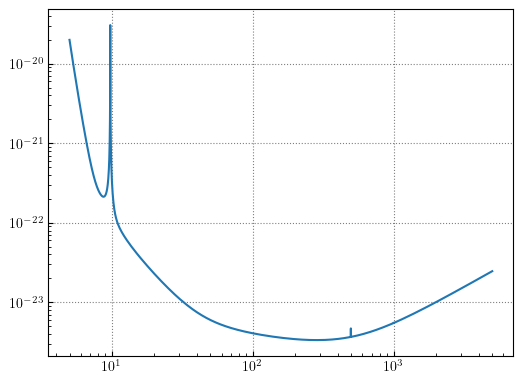

In [50]:
f_ASD,LIGO_ASD = np.loadtxt('./../input/aLIGODesign.txt',unpack=True)
fig,ax = plt.subplots()
ax.plot(f_ASD,LIGO_ASD)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [51]:
LIGO_PSD = np.interp(freqs,f_ASD,LIGO_ASD**2)

T = constants.year
sigmas = (10.*np.pi**2/(3.*constants.H0**2))*freqs**3*np.sqrt(LIGO_PSD**2)/np.sqrt(T)

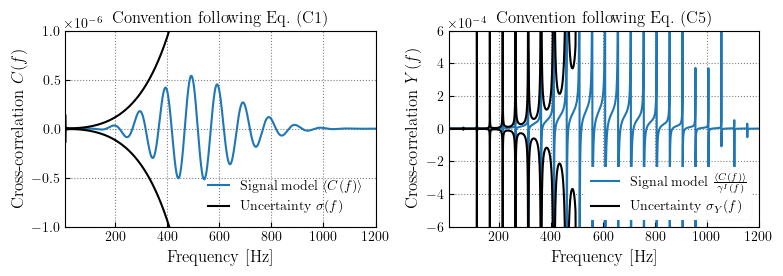

In [56]:
fig = plt.figure(figsize=(8,3))

ax = fig.add_subplot(121)
ax.plot(freqs,model_background_HL,label='Signal model $\langle C(f) \\rangle$')
ax.plot(freqs,sigmas,color='black',label='Uncertainty $\sigma(f)$')
ax.plot(freqs,-sigmas,color='black')
ax.set_xlim(10,1200)
ax.set_ylim(-1e-6,1e-6)
ax.legend(fontsize=10,loc='lower right',handlelength=1.5)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Cross-correlation $C(f)$')
ax.set_title("Convention following Eq.~(C1)",fontsize=12)

ax = fig.add_subplot(122)
ax.plot(freqs,model_background_HL/H1L1_gammaI,label=r'Signal model $\frac{\langle C(f) \rangle}{\gamma^I(f)}$')
ax.plot(freqs,np.abs(sigmas/H1L1_gammaI),color='black',label=r'Uncertainty $\sigma_Y(f)$')
ax.plot(freqs,-np.abs(sigmas/H1L1_gammaI),color='black')
ax.set_xlim(10,1200)
ax.set_ylim(-6e-4,6e-4)
legend = ax.legend(frameon=True,framealpha=1,loc='lower right',fontsize=10)
legend.get_frame().set_linewidth(0.1)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Cross-correlation $Y(f)$')
ax.ticklabel_format(useOffset=True,scilimits=(0,0),axis='y')
ax.set_title("Convention following Eq.~(C5)")

plt.tight_layout()
plt.savefig('signal_convention_cartoon.pdf',bbox_inches='tight')
plt.show()

In [113]:
f_H1L1_O3,C_H1L1_O3,sigma_H1L1_O3 = np.loadtxt('../input/H1L1_O3.dat',unpack=True,skiprows=1)

Text(0.5, 1.0, 'LVK data release (actual)')

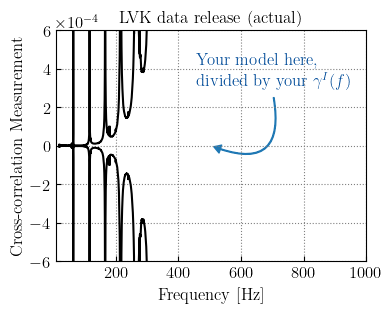

In [119]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(f_H1L1_O3,np.abs(sigma_H1L1_O3),color='black')
ax.plot(f_H1L1_O3,-np.abs(sigma_H1L1_O3),color='black')

ax.text(0.45, 0.85, 'Your model here,',horizontalalignment='left',transform=ax.transAxes,fontsize=12,color="#08519c")
ax.text(0.45, 0.76, 'divided by your $\gamma^I(f)$',horizontalalignment='left',transform=ax.transAxes,fontsize=12,color="#08519c")

style = "Simple, tail_width=0.5, head_width=6, head_length=5"
kw = dict(arrowstyle=style, color=blue)
arrow = patches.FancyArrowPatch((0.7, 0.72), (0.5, 0.5),connectionstyle="arc3,rad=-.9",transform=ax.transAxes, **kw)
ax.add_patch(arrow)

ax.set_xlim(10,1000)
ax.set_ylim(-6e-4,6e-4)
ax.set_xlabel('Frequency [Hz]',fontsize=12)
ax.set_ylabel('Cross-correlation Measurement',fontsize=12)
ax.ticklabel_format(useOffset=True,scilimits=(0,0),axis='y')
ax.set_title("LVK data release (actual)")
#ax.set_yscale('symlog',linthresh=1e-8,linscale=0.2)